# Xây dựng Chatbot sử dụng mô hình Transformer

In [ ]:
!pip install underthesea

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 6.1 MB/s 
     |████████████████████████████████| 965 kB 50.8 MB/s 
     |████████████████████████████████| 235 kB 56.5 MB/s 
     |████████████████████████████████| 581 kB 48.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re,string
from gensim.models import KeyedVectors
from collections import Counter
from underthesea import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import preprocessing, utils, activations
# from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dữ liệu chatbot question-answer short style.csv')
df.head()

,Unnamed: 0,user_a,user_b
0,0,Thích mẫu người nào,"Dễ thương, tóc dài, da trắng"
1,1,Có crush ai không,Có 1 bạn cùng lớp
2,2,Tại sao lại thích bạn dó,Vì đáp ứng những yêu cầu của tao
3,3,Có hay nói chuyện không,Hay nhắn tin messenger
4,4,Bạn kia có bắt chuyện trước không,Có đôi khi


In [ ]:
df.shape

(5900, 3)

**Text Cleaning / Preprocessing**

In [ ]:
df.isna().sum()

Unnamed: 0    0
user_a        0
user_b        1
dtype: int64

In [ ]:
idx = df[df['user_b'].isnull()].index.tolist() # Get index of nan row
print('Question of nan answer: ' ,df['user_a'][idx].values)

Question of nan answer:  ['Anh chị em làm gì?']


In [ ]:
# Fill in nan row value
df['user_b'] = df['user_b'].fillna('Luật sư').values 

In [ ]:
# Preprocessing
EMOTICONS = { 
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u":))":"Happy face smiley",
    u":)))":"Happy face smiley",
    u":))))":"Happy face smiley",
    u":'<":"Happy face smiley",
    u":)":"Happy face smiley",
    u":(":"Happy face smiley",
    u":((":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u"D:":"Sadness",
    u":O":"Surprise",
    u":o":"Surprise",
}

cnt = Counter()
for text in df["user_b"].values:
    for word in text.split():
        cnt[word] += 1

RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-10-1:-1]]) #Get top 10 rare word

def remove_emoticons(text):
    "Function to remove emoticons"
    arr = [word for word in text.split() if word not in EMOTICONS.keys()]
    return " ".join(arr)

def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

def preprocessing(df): 
  df["user_a"] = df["user_a"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation))) # Remove punctuation
  df["user_b"] = df["user_b"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation))) 
  df["user_a"] = df["user_a"].apply(lambda ele: remove_emoticons(ele)) # Remove emoticons
  df["user_b"] = df["user_b"].apply(lambda ele: remove_emoticons(ele))
  df["user_a"] = df["user_a"].apply(lambda ele: remove_rarewords(ele)) # Remove rarewords
  df["user_b"] = df["user_b"].apply(lambda ele: remove_rarewords(ele))
  df['user_b'] = df['user_b'].apply(lambda ele: 'START ' + ele + ' END')
  df["user_a"] = df["user_a"].apply(lambda ele: ele.lower()) # convert text to lowercase
  df["user_b"] = df["user_b"].apply(lambda ele: ele.lower()) 
  
  return df

df = preprocessing(df)

In [ ]:
data = df.values #numpy 
questions = data[:,1] # convert question to a list
answers = data[:,2] # convert answer that match with question to list
print(questions[:5]) 
print(answers[:5])

['thích mẫu người nào' 'có crush ai không' 'tại sao lại thích bạn dó'
 'có hay nói chuyện không' 'bạn kia có bắt chuyện trước không']
['start dễ thương tóc dài da trắng end' 'start có 1 bạn cùng lớp end'
 'start vì đáp ứng những yêu cầu của tao end'
 'start hay nhắn tin messenger end' 'start có đôi khi end']


**Tokenization and Encode, Decode**

In [ ]:
# Tokenization questions
questions = [word_tokenize(ques) for ques in questions]
print(len(questions))
print(questions[:3])

5900
[['thích', 'mẫu', 'người', 'nào'], ['có', 'crush', 'ai', 'không'], ['tại sao', 'lại', 'thích', 'bạn', 'dó']]


In [ ]:
# Tokenization answer
answers = [word_tokenize(ans) for ans in answers]
print(len(answers))
print(answers[:3])

5900
[['start', 'dễ thương', 'tóc', 'dài', 'da', 'trắng', 'end'], ['start', 'có', '1', 'bạn', 'cùng', 'lớp', 'end'], ['start', 'vì', 'đáp ứng', 'những', 'yêu cầu', 'của', 'tao', 'end']]


In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers)
VOCAB_SIZE = len(tokenizer.word_index) + 2
print( 'VOCAB SIZE : {}'.format( VOCAB_SIZE ))

VOCAB SIZE : 3645


In [ ]:
word2idx = tokenizer.word_index

In [ ]:
#encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
padded_questions = pad_sequences(tokenized_questions, maxlen = maxlen_questions, padding = 'post')
encoder_input_data = np.array(padded_questions)
print("Max length question:", maxlen_questions)
print(encoder_input_data.shape)

Max length question: 76
(5900, 76)


In [ ]:
# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
padded_answers = pad_sequences(tokenized_answers, maxlen = maxlen_answers, padding='post')
decoder_input_data = np.array(padded_answers)
print("Max length anwser:", maxlen_answers)
print(decoder_input_data.shape)

Max length anwser: 43
(5900, 43)


In [ ]:
# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences(answers)
# Remove Start added before
for i in range(len(tokenized_answers)):
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = pad_sequences(tokenized_answers, maxlen = maxlen_answers, padding='post')
#onehot_answers = tf.keras.utils.to_categorical(padded_answers, VOCAB_SIZE)
decoder_output_data = np.array(padded_answers)
print(decoder_output_data.shape)

(5900, 43)


**Word2Vec Embedding with FastText**

In [ ]:
fastText_model = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/wiki.vi.vec')
print("FastText Loaded!")

FastText Loaded!


In [ ]:
embeddings_dim = 300

embedding_matrix = np.zeros((VOCAB_SIZE, embeddings_dim))

for word, index in word2idx.items():
    try:
        embedding_matrix[index,:] = fastText_model[word]
    except:
        continue
        
print(embedding_matrix.shape)

(3645, 300)


## Transformer Structure

![](https://quantdare.com/wp-content/uploads/2021/11/transformer_arch.png)

Ta có thể thấy lớp Encoder gồm N khối (ta tạm gọi là EncoderLayer). Và đầu ra của N khối này sẽ được nối sang bên Decoder. Tương tự với đó là bên Decoder cũng chứa N khối DecoderLayer. 

### Encoder:
- Gồm lớp Embedding, Positional Encoding và các lớp Encoder 
## Lớp Encoder:
- Gồm lớp Multi-Head Attention, 2 lớp Add & Norm và 1 mạng Feed Forward

### Decoder:
- Gồm lớp Embedding, Positional Encoding và các lớp Decoder 
## Lớp Encoder:
- Gồm lớp 3 khối:
 + Masked Multi-Head Attention, 1 lớp Add & Norm 
 + Multi-Head Attention nhận 2 ma trận K,V từ lớp encoder, 1 lớp Add & Norm 
 + 1 mạng Feed Forward và 1 lớp Add & Norm 
 
### Đi qua một mạng Linear và Softmax để có được output

# Model Defination

**Attension** 

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

**Masking**

In [ ]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [ ]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

**Positional Encoding**

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

**Encoder Layer**

In [ ]:
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

**Encoder**

In [ ]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  embeddings = tf.keras.layers.Embedding(vocab_size,d_model
                                     ,input_length=maxlen_questions
                                     ,weights = [embedding_matrix]
                                     ,trainable=False)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)

**Decoder Layer**

In [ ]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

**Decoder**

In [ ]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  

  embeddings = tf.keras.layers.Embedding(vocab_size,d_model
                                     ,input_length=maxlen_answers
                                     ,weights = [embedding_matrix]
                                     ,trainable=False)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)

**Transformer**

In [ ]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)
  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)
  # mask the encoder outputs for the 2nd attention block
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size)(dec_outputs)
  #Add a softmax layer to get probability distribution of word in vocab
  outputs = tf.keras.layers.Dense(units=vocab_size, activation = 'softmax',name = "outputs")(outputs)


  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

In [ ]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 2
NUM_HEADS = 6 # model dims must divided to number of heads
UNITS = 512
DROPOUT = 0.1

In [ ]:
# Define the model
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=embeddings_dim,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

In [ ]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 300)    2434324     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

**Define Loss Function** 

In [ ]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, maxlen_answers))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

**Optimizer with custom learning rate**

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=2000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [ ]:
learning_rate = CustomSchedule(embeddings_dim)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

**Compile the model**

In [ ]:
def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, maxlen_answers))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

In [ ]:
model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [ ]:
# Training the model
history = model.fit([encoder_input_data , decoder_input_data], decoder_output_data, batch_size=64, epochs=100)

Epoch 1/100


2022-05-22 09:42:35.226073: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


93/93 [==============================] - 14s 87ms/step - loss: 0.5806 - accuracy: 0.0191
Epoch 2/100
93/93 [==============================] - 8s 88ms/step - loss: 0.4671 - accuracy: 0.0250
Epoch 3/100
93/93 [==============================] - 8s 87ms/step - loss: 0.4292 - accuracy: 0.0265
Epoch 4/100
93/93 [==============================] - 8s 86ms/step - loss: 0.3888 - accuracy: 0.0275
Epoch 5/100
93/93 [==============================] - 8s 88ms/step - loss: 0.3530 - accuracy: 0.0288
Epoch 6/100
93/93 [==============================] - 8s 87ms/step - loss: 0.3212 - accuracy: 0.0303
Epoch 7/100
93/93 [==============================] - 8s 87ms/step - loss: 0.2939 - accuracy: 0.0316
Epoch 8/100
93/93 [==============================] - 8s 86ms/step - loss: 0.2712 - accuracy: 0.0336
Epoch 9/100
93/93 [==============================] - 8s 87ms/step - loss: 0.2526 - accuracy: 0.0356
Epoch 10/100
93/93 [==============================] - 8s 89ms/step - loss: 0.2396 - accuracy: 0.0369
Epoch 11/1

**Visualize Training Progress**

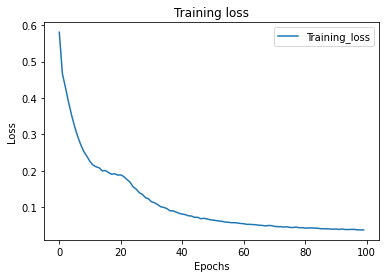

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],label='Training_loss')
plt.legend()
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()
plt.savefig('Loss_Graph')

In [ ]:
model.save_weights('chatbot_weights.h5')

**Bot Chatting**

In [ ]:
model.load_weights('/content/drive/MyDrive/chatbotTrans_weights.h5')

In [ ]:
idx2word = tokenizer.index_word

In [ ]:
def str_to_tokens(sentence):
    words = word_tokenize(sentence.lower())
    tokens_list = []
    
    for word in words:
        tokens_list.append(word2idx[word]) 
    return pad_sequences([tokens_list],maxlen = maxlen_questions , padding='post')

In [ ]:
def evaluate(sentence):
  sentence = str_to_tokens(sentence)
  output = np.zeros((1, 1))
  output[0, 0] = word2idx['start']

  for i in range(maxlen_answers):
    predictions = model(inputs=[sentence, output], training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, word2idx['end']):
      break

    # concatenated the predicted_id to the output which is given to the decoder as its input.
    output = tf.concat([output, predicted_id], axis=-1)
    
  return tf.squeeze(output, axis=0)

def predict(sentence):
  prediction = evaluate(sentence)
  predicted_sentence = " ".join(idx2word[tf.get_static_value(i)] for i in prediction if i < VOCAB_SIZE)
  return predicted_sentence.replace("start","")

In [ ]:
flag=True
print("BOT: Xin chào! Tôi là ChatBot. Nếu bạn muốn ngưng cuộc trò chuyện, hãy gõ Bye!")

while(flag==True):
    human_response = input('Enter question : ')
    if human_response != 'bye':
        try:
            print('BOT: ' + predict(human_response))
        except:
            print("BOT: Xin lỗi câu này tôi chưa đc học ,vui lòng hỏi lại :( ")
    else:
        flag=False
        print("BOT: Tạm biệt nha!")

BOT: Xin chào! Tôi là ChatBot. Nếu bạn muốn ngưng cuộc trò chuyện, hãy gõ Bye!
Enter question : người yêu bạn tên gì
BOT:  nguyệt
Enter question : người yêu bạn học ở trường nào
BOT:  mình học trường tôn đức thắng
Enter question : bạn đang học ngành gì
BOT:  kế toán
Enter question : bạn có anh chị em không
BOT:  mình có chị thôi
Enter question : nhà bạn có bao nhiêu người
BOT:  1111 số người trong nhà
Enter question : mẹ bạn làm gì
BOT:  làm hành gia
Enter question : bye
BOT: Tạm biệt nha!
